# Prepare the environment

## Import Libraries

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

## Global variables

## Load files

###  GTF file

Подгрузим gtf-файл. Для этого нам будет необходимо распарсить последний столбец

In [85]:
def parse_info(column):
    column = column.replace('"', '').split('; ')
    column_dict = dict(map(lambda x: x.split(' ')[:2], column))
    column_list_filt = [column_dict.get(key, 'NaN') for key in ['gene_id', 'exon_number', 'gene_name', 'exon_id']]
    return column_list_filt

In [86]:
gtf = pd.read_csv('../references/genome.gtf', sep='\t', header=None, skiprows=5, dtype='str', usecols=[0, 2, 3, 4, 8])
gtf.columns = ['chr_ind', 'type', 'chrstart', 'chrend', 'Info']
gtf = gtf[gtf.type == 'exon'].copy()
gtf[['gene_id', 'exon_number', 'gene_name', 'exon_id']] = gtf.Info.map(parse_info).to_list()
gtf.head()

,chr_ind,type,chrstart,chrend,Info,gene_id,exon_number,gene_name,exon_id
2,1,exon,108344807,108347562,"gene_id ""ENSMUSG00000104478""; gene_version ""2""...",ENSMUSG00000104478,1,Gm38212,ENSMUSE00001337335
5,1,exon,6980784,6981446,"gene_id ""ENSMUSG00000104385""; gene_version ""2""...",ENSMUSG00000104385,1,Gm7449,ENSMUSE00001339893
8,1,exon,108540067,108540244,"gene_id ""ENSMUSG00000101231""; gene_version ""2""...",ENSMUSG00000101231,1,Gm28283,ENSMUSE00001325295
11,1,exon,6986783,6987219,"gene_id ""ENSMUSG00000102135""; gene_version ""2""...",ENSMUSG00000102135,1,Gm37108,ENSMUSE00001339810
12,1,exon,6993624,6993812,"gene_id ""ENSMUSG00000102135""; gene_version ""2""...",ENSMUSG00000102135,2,Gm37108,ENSMUSE00001343179


### Counts

In [84]:
file_list = []
columns = []
for file in glob.glob('../countsHtseq/*'):
    sample_name = file.split('/')[-1].split('_')[0]
    df = pd.read_csv(file, sep='\t', index_col=0, header=None)
    file_list.append(df)
    columns.append(sample_name)

counts = pd.concat(file_list, axis=1)
counts.columns = columns
counts.index.name = 'gene_id'
counts.head()

,SRR3414631,SRR3414630,SRR3414636,SRR3414637,SRR3414635,SRR3414629
gene_id,,,,,,
ENSMUSG00000000001,5757,3963,3532,4078,3466,4507
ENSMUSG00000000003,0,0,0,0,0,0
ENSMUSG00000000028,472,275,137,152,152,348
ENSMUSG00000000031,65189,33334,48392,56187,55720,64723
ENSMUSG00000000037,90,71,45,54,43,81


# RPKM

Посчитаем длину экзонов для каждого гена

In [79]:
gtf['length'] = gtf['chrend'].astype(int) - gtf['chrstart'].astype(int)
gene_length = gtf[['length', 'gene_id']].groupby('gene_id').sum()
gene_length.head()

,length
gene_id,
ENSMUSG00000000001,3253
ENSMUSG00000000003,1586
ENSMUSG00000000028,6162
ENSMUSG00000000031,32498
ENSMUSG00000000037,26065


Вычислим RPKM:
$$
RPKM_i = \frac{count_i / length_i}{\sum_jcount_j} * 10^9
$$

In [97]:
# функция для подсчёта rpkm
def rpkm_calc(sample_counts):
    return sample_counts / (gene_length.length.values * sample_counts.sum()) * 1e9

In [ ]:
rpkm_norm

In [100]:
# убедимся что порядок генов в двух датафреймов совпадает
counts = counts.loc[gene_length.index]
rpkm_norm = counts.apply(rpkm_calc)
rpkm_norm.head()

,SRR3414631,SRR3414630,SRR3414636,SRR3414637,SRR3414635,SRR3414629
gene_id,,,,,,
ENSMUSG00000000001,94.946917,105.017739,68.010029,78.656989,64.631666,85.283006
ENSMUSG00000000003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSMUSG00000000028,4.109500,3.847102,1.392628,1.547733,1.496314,3.476294
ENSMUSG00000000031,107.618364,88.420599,93.272424,108.480923,104.005265,122.591684
ENSMUSG00000000037,0.185248,0.234814,0.108141,0.129990,0.100072,0.191287


Заменим названия генов для удобства

In [106]:
# create mapping dict
id_to_name = gtf[['gene_id', 'gene_name']].set_index('gene_id').gene_name.dropna().to_dict()

# replace id to names
rpkm_norm.index = rpkm_norm.index.map(lambda x: id_to_name.get(x, x))
rpkm_norm.head()

,SRR3414631,SRR3414630,SRR3414636,SRR3414637,SRR3414635,SRR3414629
gene_id,,,,,,
Gnai3,94.946917,105.017739,68.010029,78.656989,64.631666,85.283006
Pbsn,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Cdc45,4.109500,3.847102,1.392628,1.547733,1.496314,3.476294
H19,107.618364,88.420599,93.272424,108.480923,104.005265,122.591684
Scml2,0.185248,0.234814,0.108141,0.129990,0.100072,0.191287


Посмотрим на ген **Wnt4**

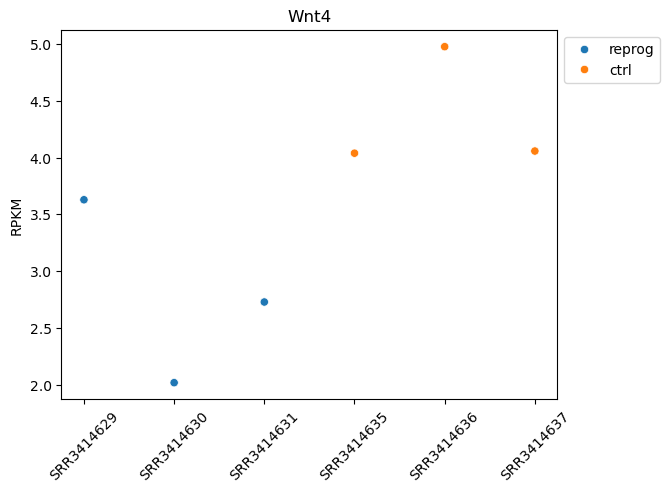

In [126]:
plot_df = rpkm_norm.loc['Wnt4'].sort_index().to_frame().reset_index()
plot_df['condition'] = ['reprog', 'reprog', 'reprog', 'ctrl', 'ctrl', 'ctrl']
ax = sns.scatterplot(plot_df, x='index', y='Wnt4', hue='condition')
ax.legend(fontsize=10, loc="upper left", bbox_to_anchor=(1, 1))
ax.set_xlabel('')
ax.set_ylabel('RPKM')
ax.set_title('Wnt4')
plt.xticks(rotation=45);